# Прогноз оттока клиентов

Цель: обучить модель машинного обучения, предсказывающую уход клиента.  
Задачи:  
- изучить исходные данные о клиентах и услугах, которыми они пользуются;  
- провести предобработку данных и подготовку признаков к обучению;  
- обучить модели машинного обучения, выбрать лучшую по метрике качества AUC-ROC;  
- провести финальное тестирование, проверить модель на адекватность.

## Изучение исходных данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from phik.phik import phik_matrix
from sklearn.model_selection import train_test_split, \
                                    GridSearchCV
from sklearn.preprocessing import OneHotEncoder, \
                                  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, \
                            roc_curve, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay
from catboost import CatBoostClassifier
import warnings

In [2]:
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 310723

In [5]:
def cat_feat_distr(data):
    fig = plt.figure(figsize=(12, 5 * (data.shape[1] - 1)))
    for col_num in range(1, data.shape[1]):
        column = data.iloc[:, col_num].value_counts()
        fig.add_subplot(data.shape[1] - 1, 1, col_num)
        plt.bar(column.index, column.values)
        plt.title(data.columns[col_num])

In [6]:
display(df_phone.head())
df_phone.info()
df_phone.describe()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


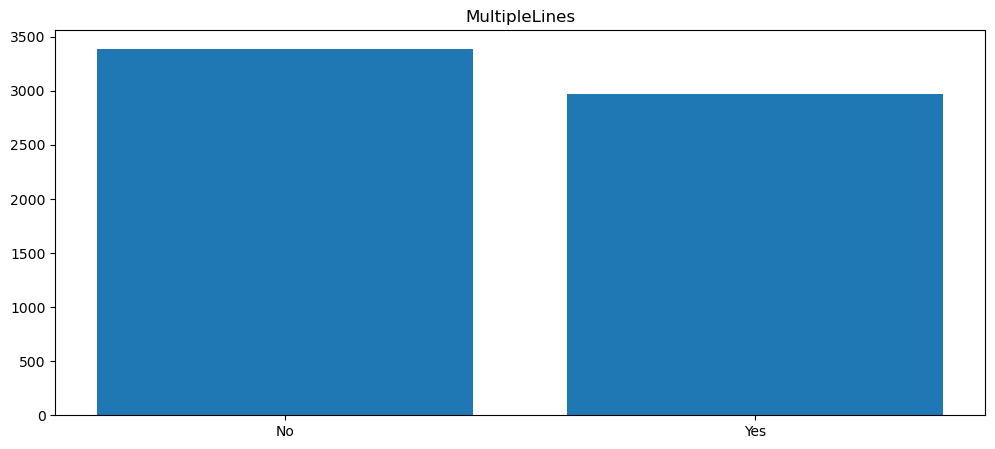

In [7]:
cat_feat_distr(df_phone)

В таблице об услугах телефонии нет пропусков, у 47% пользователей телефон подключён к нескольким линиям.

In [8]:
display(df_internet.head())
df_internet.info()
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


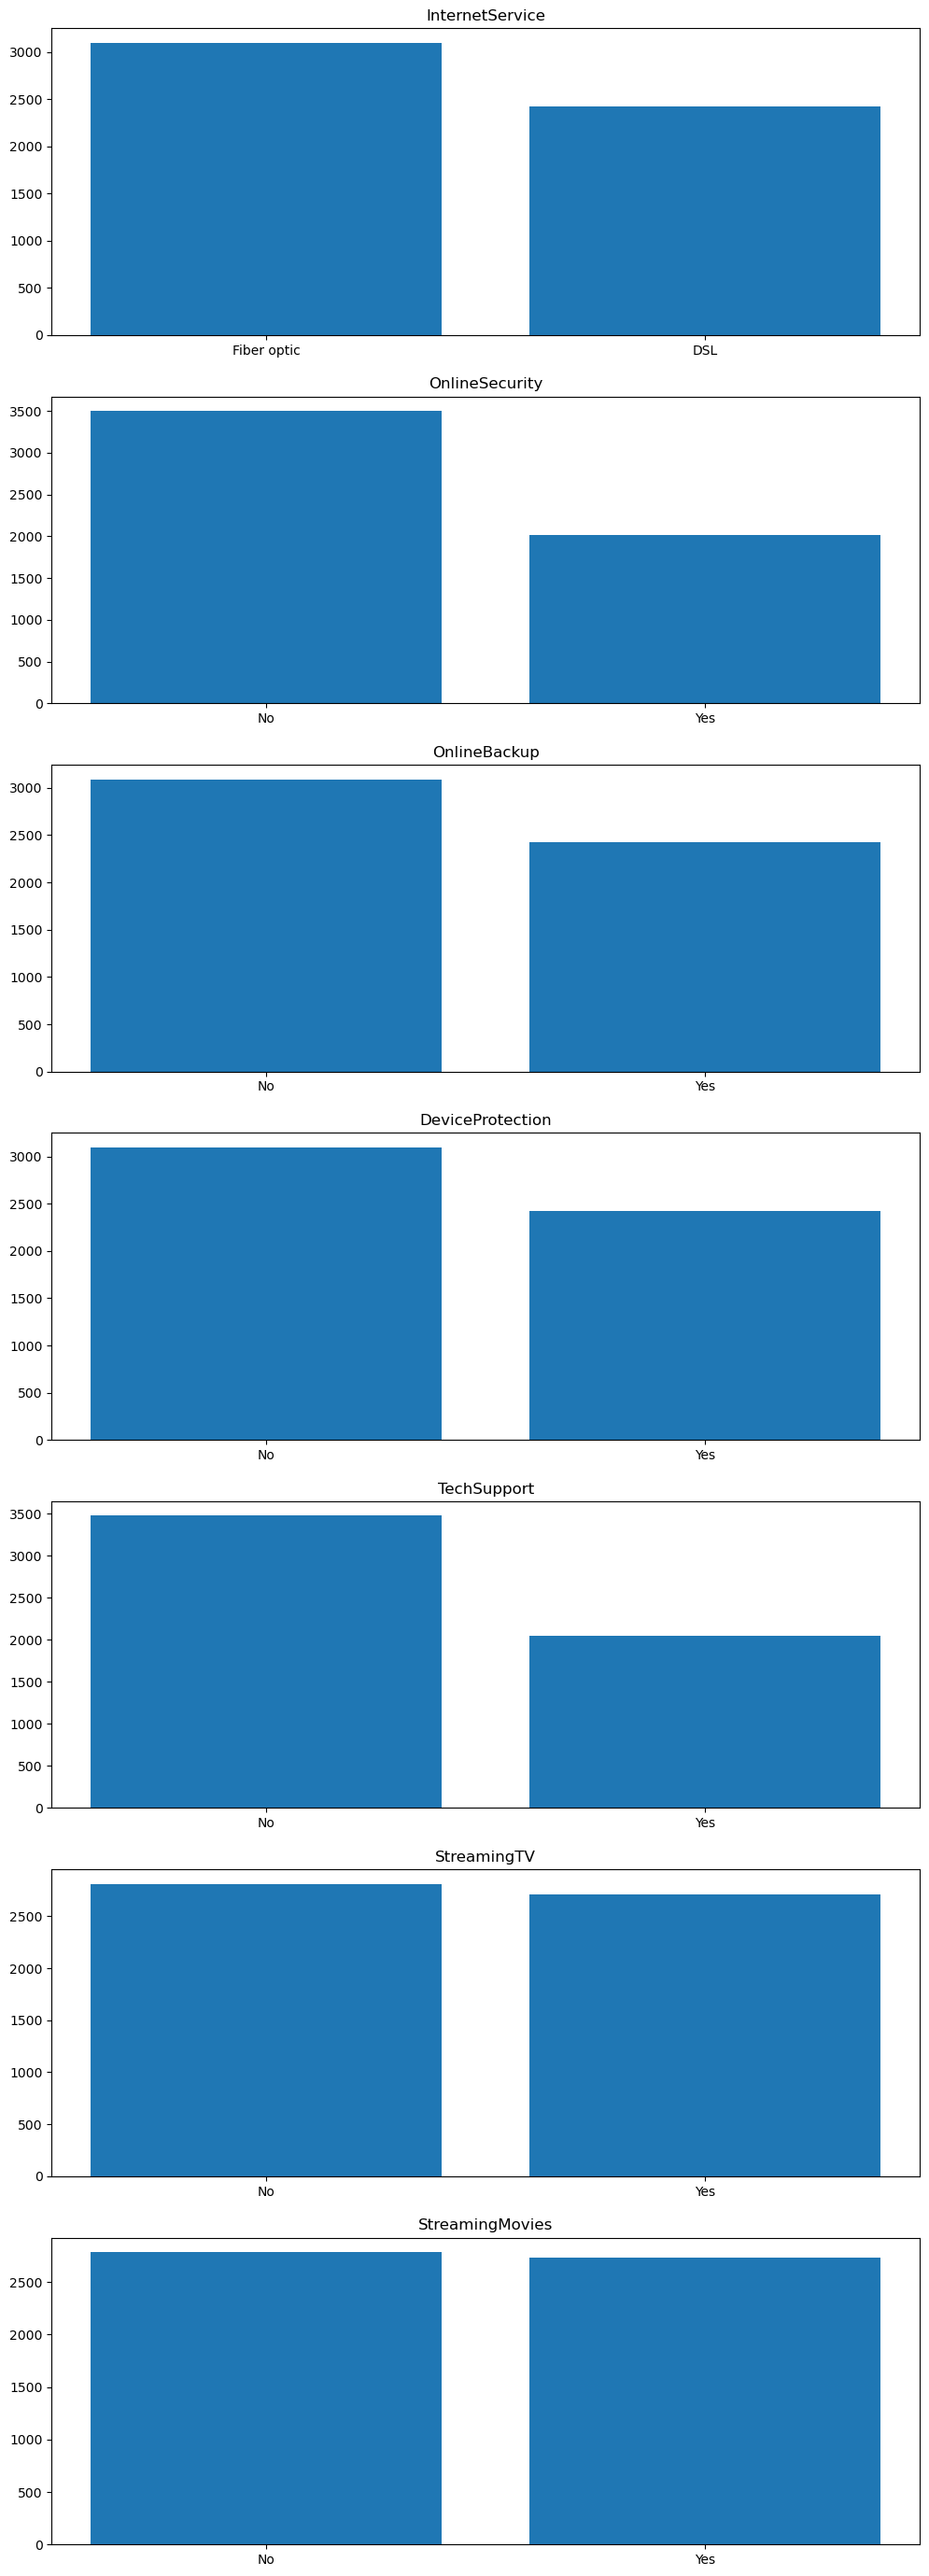

In [9]:
cat_feat_distr(df_internet)

В таблице об интернет-услугах расположена информация о типе подключения интернета для каждого пользователя и наличии дополнительных услуг.

In [10]:
display(df_personal.head())
df_personal.info()
df_personal.drop(['SeniorCitizen'], axis=1).describe()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933


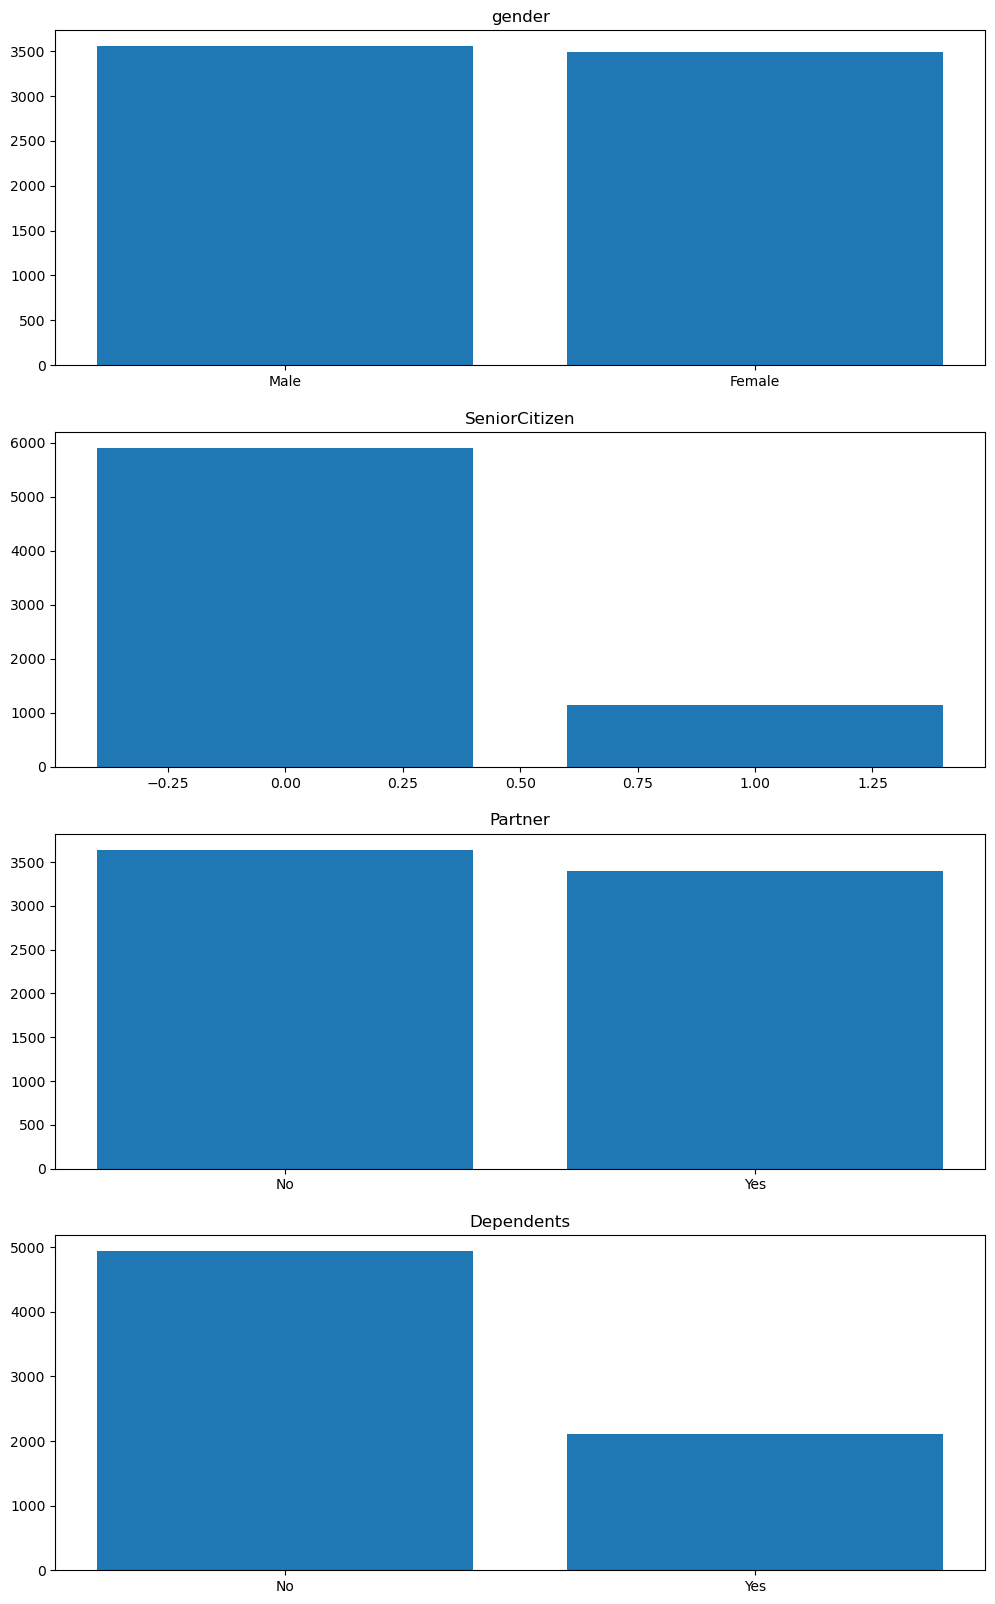

In [11]:
cat_feat_distr(df_personal)

В таблице с персональными данными содержится информация о поле клиента, семейном положении, наличии детей и о том, является ли он пенсионером.

In [12]:
display(df_contract.head())
df_contract.info()
display(df_contract.drop(['MonthlyCharges'], axis=1).describe())
df_contract['MonthlyCharges'].describe()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5942,3875,4171,2365,11


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

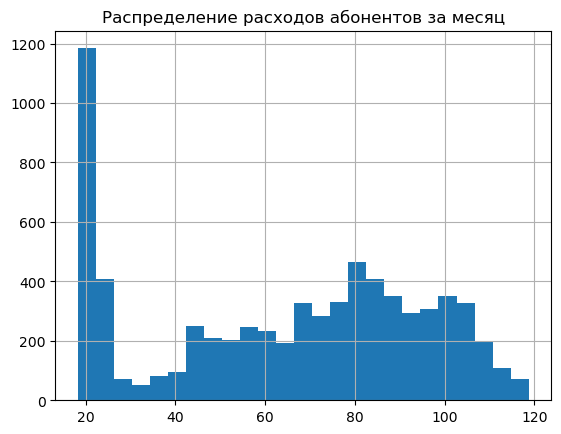

In [13]:
df_contract['MonthlyCharges'].hist(bins=25)
plt.title('Распределение расходов абонентов за месяц')
plt.show()

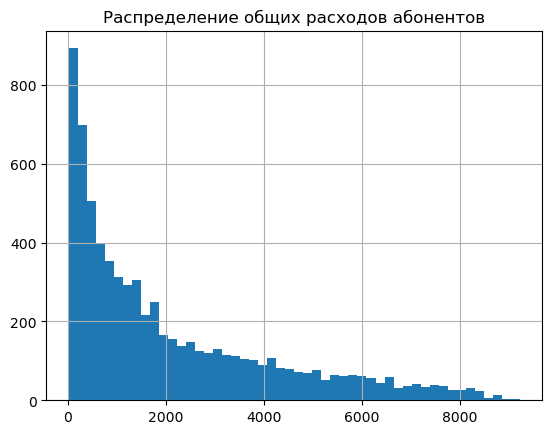

In [14]:
na_total_charge_id = df_contract.query('TotalCharges == " "').index
df_contract['TotalCharges'].drop(na_total_charge_id, axis=0).astype('float').hist(bins=50)
plt.title('Распределение общих расходов абонентов')
plt.show()

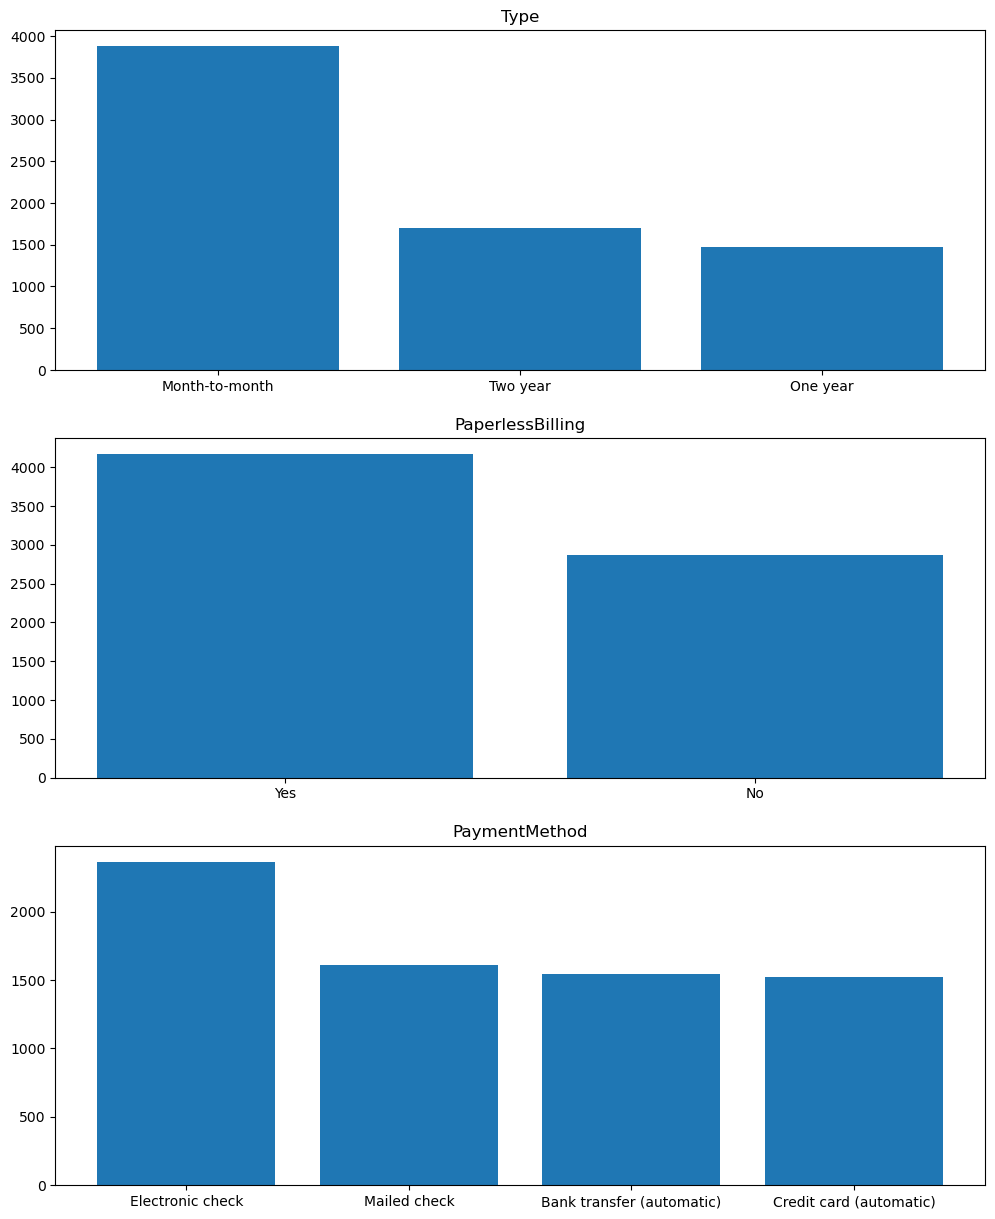

In [15]:
cat_feat_distr(df_contract.drop(['BeginDate', 'EndDate', \
                                 'MonthlyCharges', 'TotalCharges'], \
                                axis=1))

У большинства абонентов расходы за месяц не превышают 26, а общие расходы не превышают 2000. В таблице с информацией о договоре указана дата заключения договора, а также дата окончания действия договора, которая является целевым признаком в задаче. Чаще клиенты предпочитают ежемесячный способ оплаты, а получение чека в электронном формате.

Вывод: большинство категориальных признаков представлено в бинарном формате, в таблице о договорах находится целевой признак - `EndDate`, а также количественные признаки `MonthlyCharges` и `TotalCharges`, пропусков в исходных данных нет.

План работы:  
- объединить таблицы и сделать предобработку данных;
- выделить целевой признак (если дата окончания договора есть, то 1, иначе 0);  
- подготовить признаки к обучению, разделить исходные данные на тренировочную и тестовую выборки в соотношении 3:1, масштабировать и кодировать данные классом `OneHotEncoder`;  
- обучение моделей классификации и подбор гиперпараметров для достижения метрики качества ROC-AUC при кросс-валидации от 0.85;  
- проверка лучшей модели на тестовых данных, а также проверка на адекватность;  
- исследование важности признаков лучшей модели.

## Предобработка данных

In [16]:
data_full = (
    df_phone.merge(df_internet, 'outer', 'customerID')
    .merge(df_personal, 'outer', 'customerID')
    .merge(df_contract, 'outer', 'customerID')
)

In [17]:
display(data_full.head())
data_full.info()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
1,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
2,9237-HQITU,No,Fiber optic,No,No,No,No,No,No,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
3,9305-CDSKC,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
4,1452-KIOVK,Yes,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   MultipleLines     6361 non-null   object 
 2   InternetService   5517 non-null   object 
 3   OnlineSecurity    5517 non-null   object 
 4   OnlineBackup      5517 non-null   object 
 5   DeviceProtection  5517 non-null   object 
 6   TechSupport       5517 non-null   object 
 7   StreamingTV       5517 non-null   object 
 8   StreamingMovies   5517 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Пропуски в данных заполним значением 'No'. Данное заполнение особенно подходит для пропусков в столбцах из таблицы с интернет услугами, так как есть два типа подключения интернета. Если в ячейке стоит пропуск, значит у пользователя нет интернета, а следовательно дополнительных услуг.

In [18]:
data_full = data_full.fillna('No')

In [19]:
# После объединения таблиц столбец 'customerID' не пригодится, поэтому его удаляем.
data_full = data_full.drop(['customerID'], axis=1)

In [20]:
# В столбце 'TotalCharges' присутствует одинадцать пустых значений,
# поэтому данные строки удаляем из общего датасета.
data_full = data_full.drop(data_full[data_full['TotalCharges'] == ' '].index, axis=0)

# Меняем тип данных столбца со строкового на число с плавающей точкой.
data_full['TotalCharges'] = data_full['TotalCharges'].astype('float')

In [21]:
# Создаём целевой признак - факт ухода клиента.
# Значение 1 говорит об уходе клиента.
data_full['client_left'] = [0] * data_full.shape[0]
contract_terminated_id = data_full['EndDate'][data_full['EndDate'] != 'No'].index
data_full['client_left'].loc[contract_terminated_id] = 1

In [22]:
# В столбце 'EndDate' меняем значения 'No' на '2020-02-01',
# так как Информация о договорах актуальна на 1 февраля 2020 по условию.
data_full['EndDate'] = np.where(data_full['EndDate'] == 'No', '2020-02-01', data_full['EndDate'])

In [23]:
# Меняем тип данных столбцов 'BeginDate' и 'EndDate' на datetime.
data_full['BeginDate'] = pd.to_datetime(data_full['BeginDate'], format='%Y-%m-%d')
data_full['EndDate'] = pd.to_datetime(data_full['EndDate'], format='%Y-%m-%d')

In [24]:
# Создаём столбец, содержащий информацию о количестве дней,
# в течение которых обслуживается клиент.
data_full['days_served'] = (data_full['EndDate'] - data_full['BeginDate']).dt.days

In [25]:
# Удаляем лишние столбцы из датасета.
data_full = data_full.drop(['BeginDate', 'EndDate'], axis=1)

In [26]:
# Переименовываем столбцы.
data_full.columns = ['multiple_lines', 'internet_service', 'online_security', \
                     'online_backup', 'device_protection', 'tech_support', \
                     'streaming_tv', 'streaming_movies', 'gender', \
                     'senior_citizen', 'partner', 'dependents', \
                     'type', 'paperless_billing', 'payment_method', \
                     'monthly_charges', 'total_charges', 'client_left', \
                     'days_served']

Проверим признаки на мультиколлинеарность. Построим матрицу корреляций.

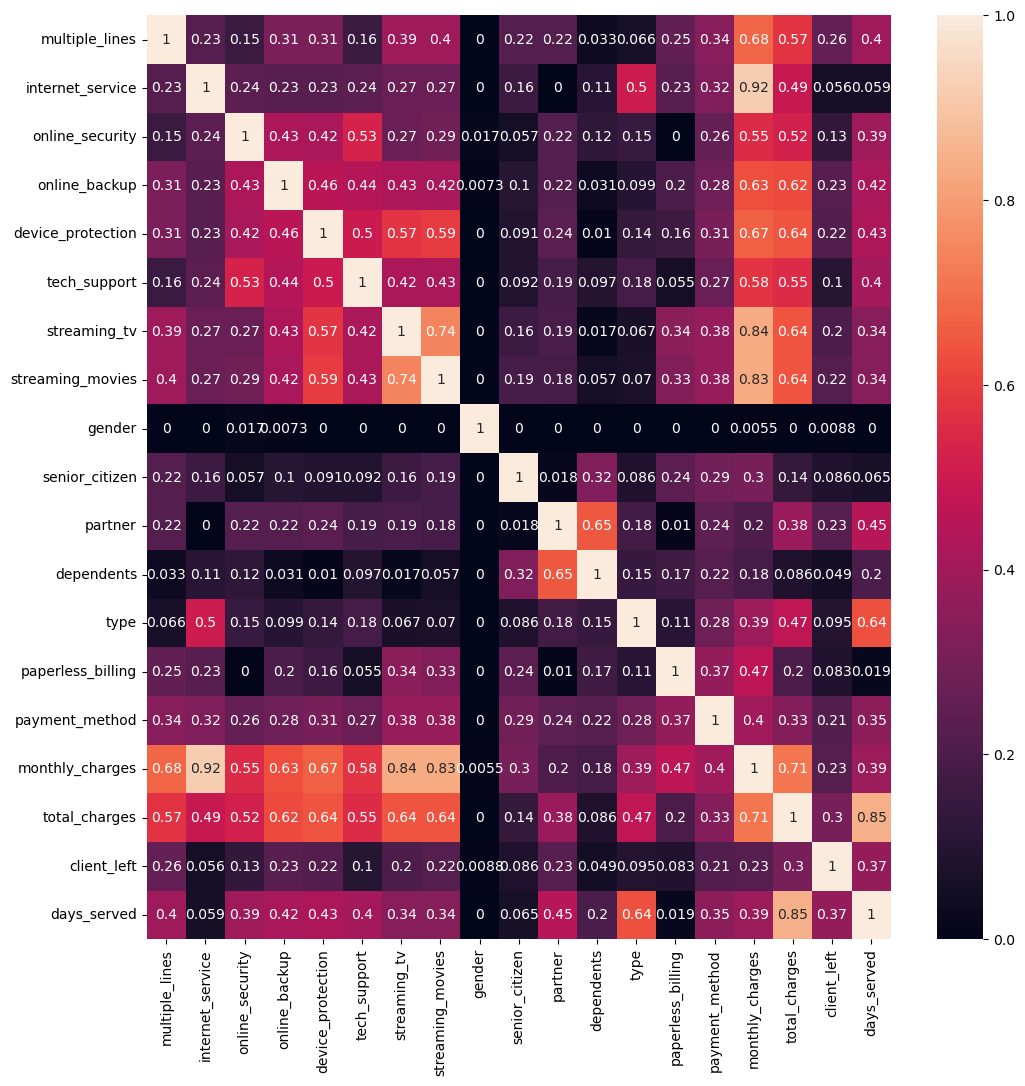

In [27]:
correlation = data_full.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'days_served'])
plt.figure(figsize=(12,12))
sns.heatmap(correlation, annot=True)
plt.show()

In [28]:
# У признака 'monthly_charges' высокий коэффициент корреляции
# с тремя признаками: 'internet_service', 'streaming_tv', 'streaming_movie'.
# Данный столбец уберём из датасета.
data_full = data_full.drop(['monthly_charges'], axis=1)

Вывод: таблицы объеденины без потери данных. Пропуски заполнены при помощи строки 'No'. Строки с пробелом в столбце `TotalCharges` удалены, тип данных столбца изменён на `float`. Выделен целевой признак. Удалены столбцы, которые не пригодятся далее для решения задачи. Построена матрица корреляций признаков, удалён признак `monthly_charges`, так как сильно коррелирует с тремя признаками.

## Подготовка к обучению

In [29]:
# Выделим целевой признак и признаки для обучения модели.
features = data_full.drop(['client_left'], axis=1)
target = data_full['client_left']

In [30]:
# Выделим обучающую и тестовую выборки в соотношении 3:1.
features_train, features_test, \
target_train, target_test = train_test_split(features, target, \
                                             test_size=.25, \
                                             random_state=RANDOM_STATE)

In [31]:
# Масштабируем численные признаки.
scaler = StandardScaler()
features_train[['total_charges', \
                'days_served']] = scaler.fit_transform(features_train[['total_charges', \
                                                                       'days_served']])
features_test[['total_charges', \
               'days_served']] = scaler.transform(features_test[['total_charges', \
                                                                 'days_served']])

In [32]:
# Методом прямого кодирования закодируем категориальные признаки
# со строковым типом данных.
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(features_train[features_train.columns[features_train.dtypes == 'object']])

OneHotEncoder(drop='first', sparse=False)

In [33]:
features_train[encoder.get_feature_names_out()] = (
    encoder.transform(features_train[features_train.columns[features_train.dtypes == 'object']])
)
features_train = features_train.drop(features_train.columns[features_train.dtypes == 'object'], axis=1)

In [34]:
features_test[encoder.get_feature_names_out()] = (
    encoder.transform(features_test[features_test.columns[features_test.dtypes == 'object']])
)
features_test = features_test.drop(features_test.columns[features_test.dtypes == 'object'], axis=1)

Вывод: выделены признаки и целевой признак в отдельные переменные. Данные разделены на обучающую и тестовую выборку в соотношении 3:1. Проведено масштабирование и прямое кодирование признаков.

## Обучение моделей

Обучим модель логистической регрессии.

In [35]:
# Задаём гиперпараметры для перебора в логистической регрессии
lr_params = {'C': np.arange(.2, 2.2, .2),
             'solver': ('lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga')}
model_lr = LogisticRegression(random_state=RANDOM_STATE)
clf1 = GridSearchCV(model_lr, lr_params, scoring='roc_auc')

In [36]:
clf1.fit(features_train, target_train)

GridSearchCV(estimator=LogisticRegression(random_state=310723),
             param_grid={'C': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
                         'solver': ('lbfgs', 'liblinear', 'newton-cg', 'sag',
                                    'saga')},
             scoring='roc_auc')

In [37]:
lr_auc_roc = clf1.best_score_

Обучим модель случайного леса.

In [38]:
rf_params = {'n_estimators': range(135, 151, 5),
             'max_depth': range(1, 10)}
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
clf2 = GridSearchCV(model_rf, rf_params, scoring='roc_auc')

In [39]:
clf2.fit(features_train, target_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=310723),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(135, 151, 5)},
             scoring='roc_auc')

In [40]:
rf_auc_roc = clf2.best_score_

Обучим модель градиентного бустинга.

In [41]:
cb_params = {'depth' : [1, 3, 5],
             'learning_rate': [0.05, 0.1],
             'iterations': np.arange(710, 721, 10)}
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
clf3 = GridSearchCV(model_cb, cb_params, scoring='roc_auc')

In [42]:
clf3.fit(features_train, target_train)

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000001C840677550>,
             param_grid={'depth': [1, 3, 5], 'iterations': array([710, 720]),
                         'learning_rate': [0.05, 0.1]},
             scoring='roc_auc')

In [43]:
clf3.best_params_

{'depth': 3, 'iterations': 720, 'learning_rate': 0.1}

In [44]:
cb_auc_roc = clf3.best_score_

In [45]:
# Построим таблицу со значениями метрики качества AUC_ROC для каждой обученной модели.
pd.DataFrame([lr_auc_roc, rf_auc_roc, cb_auc_roc], 
             index=['logistic_regression', 'random_forest', 'catboost'],
             columns=['AUC_ROC'])

,AUC_ROC
logistic_regression,0.764526
random_forest,0.829463
catboost,0.923842


Высший показатель метрики качества удалось получить при обучении модели градиентного бустинга. Финальное тестирование проведём на данной модели.

In [46]:
best_model = clf3.best_estimator_

## Тестирование модели

Проверим значение AUC_ROC модели градиентного бустинга catboost на тестовых данных.

In [47]:
# Сохраняем предсказанные моделью вероятности ухода клиента в отдельную переменную.
prob_one = best_model.predict_proba(features_test)[:, 1]

In [48]:
# Рассчитываем метрику качества.
auc_roc = roc_auc_score(target_test, prob_one)
print(f'Значение AUC_ROC модели градиентного бустинга на тестовых данных = {auc_roc:.4}')

Значение AUC_ROC модели градиентного бустинга на тестовых данных = 0.9218


Проверим модель на адекватность.

In [49]:
dummy_model = DummyClassifier()
dummy_model.fit(features_test, target_test)
dummy_prob_one = dummy_model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, dummy_prob_one)
print(f'AUC_ROC дамми модели = {auc_roc}')

AUC_ROC дамми модели = 0.5


Построим ROC-кривую.

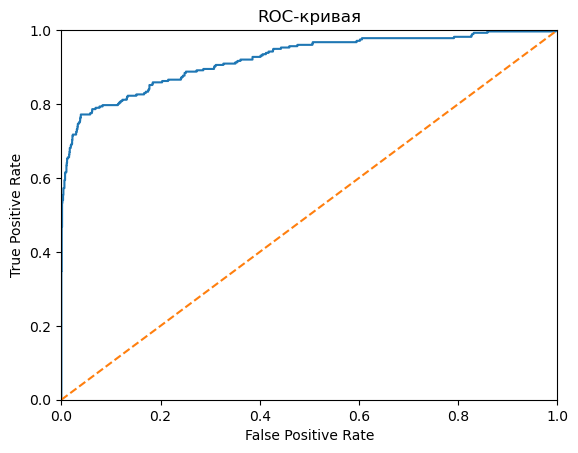

In [50]:
fpr, tpr, thresholds = roc_curve(target_test, prob_one)

# Строим ROC-кривую
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая дамми модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Проанализируем важность признаков для модели.

In [51]:
feature_importance = pd.DataFrame(data=best_model.get_feature_importance().round(2),
                                  columns=['feature_rating'])
feature_importance['feature'] = features_test.columns
feature_importance = feature_importance.sort_values(by='feature_rating', ascending=False)

In [52]:
feature_importance

,feature_rating,feature
2,70.42,days_served
1,9.67,total_charges
16,4.06,type_Two year
13,2.32,partner_Yes
7,2.16,online_backup_Yes
3,1.91,multiple_lines_Yes
15,1.51,type_One year
20,1.41,payment_method_Mailed check
8,0.86,device_protection_Yes
14,0.75,dependents_Yes


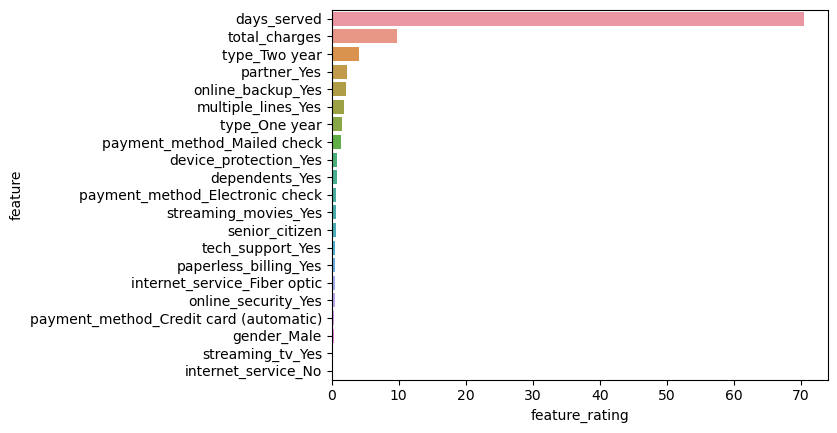

In [53]:
sns.barplot(data=feature_importance, x="feature_rating", y="feature")
plt.show()

В топ 5 важных признаков входят:  
- количество дней со дня заключения договора;  
- общая сумма, оплаченная пользователем за всё время действия договора;  
- тип оплаты;
- факт наличия партнёра у клиента;  
- услуга облачного хранилища файлов для резервного копирования данных.

Вывод: модель градиентного бустинга успешно прошла финальное тестирование на тестовой выборке. Метрика качества AUC_ROC превышает установленный по задаче порог 0.85. Модель проверена на адекватность, метрика качества выше, чем у дамми модели, следовательно модель адекватная. Выделены топ 5 признаков по важности для модели, особенно выделяется признак с количеством дней со дня заключения договора.

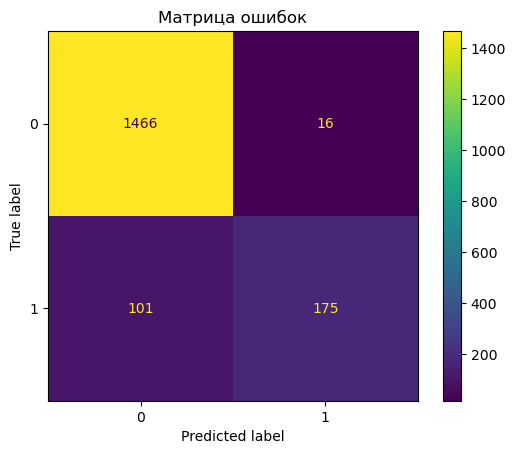

In [54]:
# Построим матрицу ошибок.
cb_model_pred = best_model.predict(features_test)
cm = confusion_matrix(target_test, cb_model_pred)
disp = ConfusionMatrixDisplay(cm, \
                              display_labels=best_model.classes_)
disp.plot()
plt.title('Матрица ошибок')
plt.show()

Модель верно определила 1466 клиентов, которые не расторгли контракт, и 175 клиентов, которые отказались от услуг компании. Модель некорректно выявила 101 человек, прекративших обслуживание, и 16 человек, которые продолжают пользоваться услугами.

## Общий вывод

Изучение исходных данных.  
Были загружены необходимые для проведения работы библиотеки, установлена константа RANDOM_STATE = 310723, загружены исходны данные, содержащие информацию о договорах, персональных данных, интернет-услугах и услугах телефонии клиентов, и сформированы в виде датафреймов.  
Построены столбчатые диаграммы по качественным и гистрограммы по количественным признакам. Выявлено, что большинство признаков представлены в бинарном виде, а столбец `EndDate`, включающий информацию о дате расторжения договора, отвечает за дальнейшее формирование целевого признака.  
На этапе исследовательского анализа данных пропуски не выявлены.

Предобработка данных.  
Загруженные таблицы объединены в одну по столбцу с идентификатором пользователя `customerID`.  
Пропущенные значения заполнены значением 'No', так как оно наиболее подходящее для большинства столбцов, особенно для признаков таблицы об интернет-услугах. Заполнение пропусков заглушкой, например 'unknown' приводит к появлению мультиколлинеарности, что плохо отражается на обучении линейных моделей.  
Удалён столбец 'customerID', так как он был необходим только для объединения датафреймов.  
В столбце `TotalCharges` обнаружено 11 пустых значений в виде пробела, данные строки были удалены.  
Создан целевой признак `client_left` при помощи данных столбца `EndDate`, где 1 означает факт расторжения договора.  
Добавлен признак `days_served` указывающий количество дней, в течение которых обслуживался клиент.  
Удалены столбцы с датами, так как более в работе они не пригодились.  
Переименованы столбцы для упрощённого обращения к ним.  
Построена матрица корреляций методом 'phik_matrix'. Выявлены высокие коэффициенты корреляции признака `monthly_charges` - месячный платёж с тремя признаками, вследствие чего данный признак был удалён.

Подготовка к обучению.  
Признаки и целевой признак выделены в разные выборки.  
Данные разделены на обучающие и тестовые в соотношении 3:1.  
Проведено масштабирование и прямое кодирование признаков.  
Признаки для обучения моделей:  
- количество дней, которых обслуживается клиент;  
- оплата за всё время обслуживания;  
- тип оплаты;  
- наличие супруга/супруги;  
- облачное хранилище файлов для резервного копирования данных;  
- подключение телефона к нескольким линиям одновременно;  
- тип платежа;  
- антивирус;  
- наличие детей;  
- каталог фильмов;  
- является ли абонент пенсионером;  
- выделенная линия технической поддержки;  
- электронный расчётный лист;  
- тип подключения;  
- блокировка опасных сайтов;  
- пол клиента;  
- стриминговое телевидение.

Обучение моделей.  
Обучение проводилось путём перебора сеток гиперпараметров для каждой модели и оценки качества кросс-валидацией.  
Выбраны 3 модели, по итогам обучения которых достигнуты следующие показатели метрики AUC ROC:  
- логистическая регрессия = 0.76;  
- случайный лес = 0.83;  
- градиентный бустинг (catboost) = 0.92.  

Модель градиентного бустинга показала самый высокий показатель метрики качества, поэтому выбрана для финального тестирования.  
Гиперпараметры лучшей обученной модели:  
- максимальная глубина дерева = 3;  
- количество итераций обучения = 720;  
- коэффициент обучения = 0.1.

Тестирование модели.  
Рассчитана метрика AUC ROC на тестовых данных - 0.9218.  
Модель градиентного бустинга прошла проверку на адекватность.  
Построена визуализация ROC-кривой, отображающая высокую метрику качества.  
Проведён анализ важности признаков для модели. Самые важные признаки:  
- количество дней со дня заключения договора;  
- общая сумма, оплаченная пользователем за всё время действия договора;  
- тип оплаты;
- факт наличия партнёра у клиента;  
- услуга облачного хранилища файлов для резервного копирования данных.  

Построена матрица ошибок, по которой удалось установить, что модель хорошо определяет людей, которые не уходят из компании, почти 99.99% верно угаданных ответов. Это позволит снизить расходы на удержание клиентов. Но модель плохо предсказывает факт ухода клиента (удалось предсказать лишь 63.4%). Это происходит ввиду малого количества данных о клиентах, которые расторгли договор.

Рекомендация заказчику.  
Необходимо принять во внимание другие метрики качества - точность, полнота, f1-мера. Улучшение этих метрик позволит лучше определять клиентов, которые собираются отказаться от услуг, что в свою очередь укажет на необходимость предложения специальных условий для их удержания.